In [1]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import LSTM,BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.


In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
#def confusion_matrix(Y_true, Y_pred):
    #Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'F:\\Python\\Appliedai\\Human recognition\\HAR\\UCI_HAR_Dataset\\{subset}\\Inertial Signals\\{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'F:\\Python\\Appliedai\\Human recognition\\HAR\\UCI_HAR_Dataset\\{subset}\\y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [11]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [12]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [13]:
# number f time steps = 128 , at every time step the input dim is 9, corresponding to the 9 time series data
# there are 7352 total number of windows/time series and each window corresponds to 1 time series which is 128 timesteps long
# and at each timestep there are 9 readings .
# for each time series we have to predict what is the class label from 1 to 6
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [14]:
#function to plot Categorical Crossentropy Loss VS No. of epochs plot
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,6))
    plt.plot(x, ty, 'b', label="Train Loss")
    plt.plot(x, vy, 'r', label="Validation/Test Loss")
    plt.title('\nCategorical_crossentropy Loss VS Epochs')
    plt.xlabel('Epochs') 
    plt.ylabel('Categorical Crossentropy Loss-Train and Test loss')
    plt.legend()
    plt.grid()
    plt.show()

## Defining the Architecture of LSTM

### Model with 1 LSTM  layer with 32 hidden units  and  Dropout 

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [102]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import LSTM,BatchNormalization

# Initializing parameters
epochs = 20
batch_size = 32
n_hidden = 32

# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
# Adding a dropout layer , to avoid overfitting
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                5376      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 5,702
Trainable params: 5,638
Non-trainable params: 64
_________________________________________________________________


In [42]:
import warnings
warnings.filterwarnings("ignore")


In [43]:
import warnings
warnings.filterwarnings("ignore")

# Compiling the model  , loss is categorical_crossentropy , as the problem is multi-class classification
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# Training the model
history = model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 25s 3ms/step - loss: 1.1224 - acc: 0.5545 - val_loss: 0.7203 - val_acc: 0.7177
Epoch 2/20
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7228 - acc: 0.6902 - val_loss: 0.9391 - val_acc: 0.5850
Epoch 3/20
7352/7352 [==============================] - 24s 3ms/step - loss: 0.5412 - acc: 0.7790 - val_loss: 0.6111 - val_acc: 0.7665
Epoch 4/20
7352/7352 [==============================] - 22s 3ms/step - loss: 0.4082 - acc: 0.8455 - val_loss: 0.5761 - val_acc: 0.8320
Epoch 5/20
7352/7352 [==============================] - 23s 3ms/step - loss: 0.3278 - acc: 0.8803 - val_loss: 0.5876 - val_acc: 0.8694
Epoch 6/20
7352/7352 [==============================] - 23s 3ms/step - loss: 0.2590 - acc: 0.9094 - val_loss: 0.5522 - val_acc: 0.8721
Epoch 7/20
7352/7352 [==============================] - 22s 3ms/step - loss: 0.2263 - acc: 0.9246 - val_loss: 0.5993 - val_acc: 0.8633
Epoch 8

### Plotting the error plot

Test score: 0.5651354040048198
Test accuracy: 0.8982015609093994


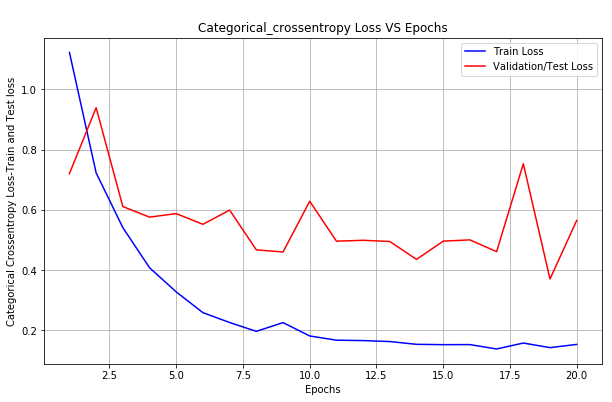

In [48]:
import matplotlib.pyplot as plt
# Evaluating the model on test data
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, epochs+1))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

### Confusion matrix

In [49]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 521        0         0        0                   0   
SITTING                  0      367        97        0                   1   
STANDING                 0       55       461        0                   0   
WALKING                  0        0         0      437                   3   
WALKING_DOWNSTAIRS       0        0         0        0                 410   
WALKING_UPSTAIRS         0        0         0        6                  14   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            16  
SITTING                           26  
STANDING                          16  
WALKING                           56  
WALKING_DOWNSTAIRS                10  
WALKING_UPSTAIRS                 451  


- With a simple 2 layer architecture we got 89.82% accuracy and a multi class log-loss of 0.56 which is categorical cross entropy.
- We can further imporve the performace with Hyperparameter tuning

### Model with 1 LSTM layer  with 64 hidden units and Dropout

In [52]:
import warnings
warnings.filterwarnings("ignore")

# Initializing parameters
epochs = 30
batch_size = 32

# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(64, input_shape=(timesteps, input_dim)))
model1.add(BatchNormalization())
# Adding a dropout layer , to avoid overfitting
model1.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 19,590
Trainable params: 19,462
Non-trainable params: 128
_________________________________________________________________


In [55]:
# Reference -   https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://keras.io/callbacks/
import warnings
warnings.filterwarnings("ignore")
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Compiling the model  , loss is categorical_crossentropy , as the problem is multi-class classification
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# specifying the filepath to store the best model 
filepath = "HAR_bestmodel_LSTM.hdf5"
# early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=1)
# model checkpoint to save the model with best accuracy
mc = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# Training the model
history = model1.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs, verbose=2, callbacks=[es, mc])

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 36s - loss: 0.1869 - acc: 0.9339 - val_loss: 0.6852 - val_acc: 0.8595

Epoch 00001: val_acc improved from -inf to 0.85952, saving model to HAR_bestmodel_LSTM.hdf5
Epoch 2/30
 - 34s - loss: 0.1994 - acc: 0.9350 - val_loss: 0.5138 - val_acc: 0.9060

Epoch 00002: val_acc improved from 0.85952 to 0.90601, saving model to HAR_bestmodel_LSTM.hdf5
Epoch 3/30
 - 36s - loss: 0.1750 - acc: 0.9359 - val_loss: 0.2713 - val_acc: 0.9328

Epoch 00003: val_acc improved from 0.90601 to 0.93281, saving model to HAR_bestmodel_LSTM.hdf5
Epoch 4/30
 - 34s - loss: 0.1731 - acc: 0.9403 - val_loss: 0.2215 - val_acc: 0.9165

Epoch 00004: val_acc did not improve from 0.93281
Epoch 00004: early stopping


### Plotting the error plot

In [59]:
#function to plot Categorical Crossentropy Loss VS No. of epochs plot
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,6))
    plt.plot(x, ty, 'b', label="Train Loss")
    plt.plot(x, vy, 'r', label="Validation/Test Loss")
    plt.title('\nCategorical_crossentropy Loss VS Epochs')
    plt.xlabel('Epochs') 
    plt.ylabel('Categorical Crossentropy Loss-Train and Test loss')
    plt.legend()
    plt.grid()
    plt.show()

Test score: 0.2712926466724943
Test accuracy: 0.9328130302002036


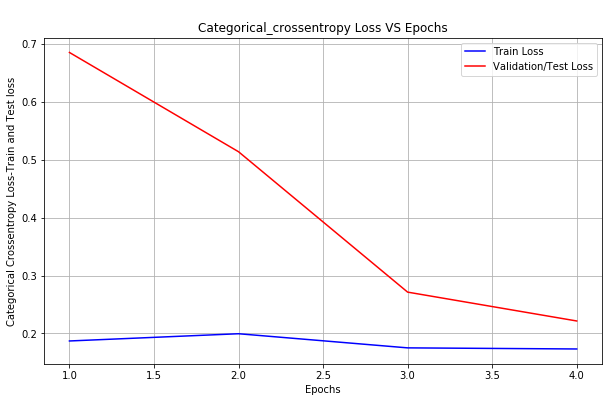

In [64]:
# Reference -  https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

from keras.models import load_model

# Saving the best model
saved_model = load_model('HAR_bestmodel_LSTM.hdf5')

# Evaluating the model on test data
score1 = saved_model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score1[0]) 
print('Test accuracy:', score1[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, 5))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

### Confusion Matrix

In [99]:
# Utility function to print the confusion matrix
import seaborn as sns
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    plt.figure(1,figsize=(10,8))
    df=pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels'])
    sns.heatmap(df, annot=True,cmap='RdPu',fmt='g')
    return pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels']) 

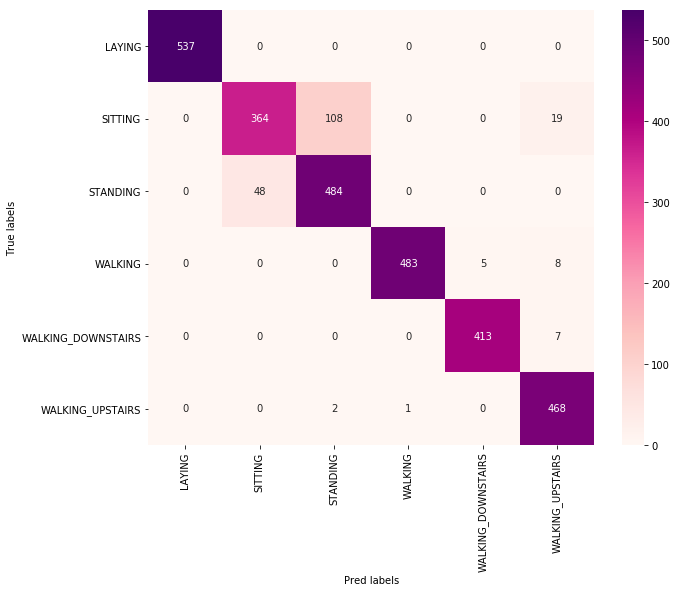

In [100]:
Y_pred = saved_model.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

#### Observation :-

With a simple 1 LSTM layer with 64 hidden layers and dropout layer architecture we got 93.28% accuracy and a multi class log-loss of 0.27 which is categorical cross  entropy.

### Model with 2 LSTM layers with 32 hidden units and Dropout

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import LSTM,BatchNormalization

# Initializing parameters
epochs = 30
batch_size = 32

# Initiliazing the sequential model
model2 = Sequential()
# Adding LSTM and Configuring the parameters
model2.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True))
model2.add(BatchNormalization())
# Adding a dropout layer , to avoid overfitting
model2.add(Dropout(0.7))
# Adding LSTM layer
model2.add(LSTM(32))
# Adding dropout
model2.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 32)           128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 14,022
Trainable params: 13,958
Non-trainable params: 64
_________________________________________________________________


In [25]:
import warnings
warnings.filterwarnings("ignore")


In [28]:
# Reference -   https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://keras.io/callbacks/
import warnings
warnings.filterwarnings("ignore")
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Compiling the model  , loss is categorical_crossentropy , as the problem is multi-class classification
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# specifying the filepath to store the best model 
filepath = "HAR_model2_LSTM.hdf5"
# early stopping
es2 = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
# model checkpoint to save the model with best accuracy
mc2 = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# Training the model
history = model2.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs, verbose=2, callbacks=[es2, mc2])

# Saving the best model
saved_model2 = load_model('HAR_model2_LSTM.hdf5')


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 55s - loss: 0.2233 - acc: 0.9290 - val_loss: 0.3942 - val_acc: 0.8894

Epoch 00001: val_acc improved from -inf to 0.88938, saving model to HAR_model2_LSTM.hdf5
Epoch 2/30
 - 51s - loss: 0.2160 - acc: 0.9252 - val_loss: 0.3732 - val_acc: 0.9043

Epoch 00002: val_acc improved from 0.88938 to 0.90431, saving model to HAR_model2_LSTM.hdf5
Epoch 3/30
 - 53s - loss: 0.2175 - acc: 0.9279 - val_loss: 0.4823 - val_acc: 0.8819

Epoch 00003: val_acc did not improve from 0.90431
Epoch 4/30
 - 50s - loss: 0.2216 - acc: 0.9285 - val_loss: 0.5732 - val_acc: 0.8765

Epoch 00004: val_acc did not improve from 0.90431
Epoch 5/30
 - 51s - loss: 0.1842 - acc: 0.9391 - val_loss: 0.3775 - val_acc: 0.9023

Epoch 00005: val_acc did not improve from 0.90431
Epoch 6/30
 - 49s - loss: 0.1985 - acc: 0.9323 - val_loss: 0.3977 - val_acc: 0.8955

Epoch 00006: val_acc did not improve from 0.90431
Epoch 7/30
 - 51s - loss: 0.1880 - acc: 0.9329 - val_loss: 0.

### Plotting the error plot

Test score: 0.34682589094722394
Test accuracy: 0.9246691550729556


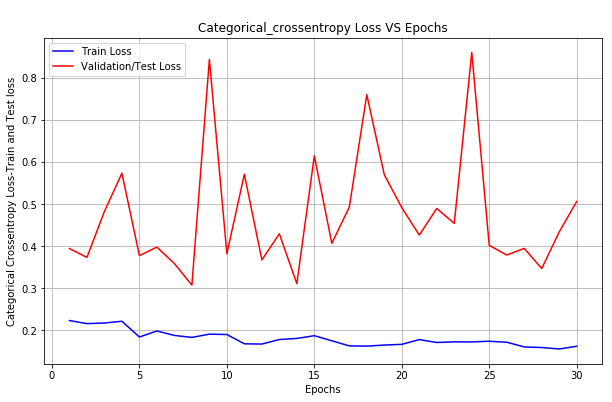

In [34]:
# Reference -  https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

from keras.models import load_model
import matplotlib.pyplot as plt

# Evaluating the model on test data
score2 = saved_model2.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score2[0]) 
print('Test accuracy:', score2[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, epochs+1))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

### Confusion matrix

In [35]:
# Utility function to print the confusion matrix
import seaborn as sns
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    plt.figure(1,figsize=(10,8))
    df=pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels'])
    sns.heatmap(df, annot=True,cmap='RdPu',fmt='g')
    return pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels']) 

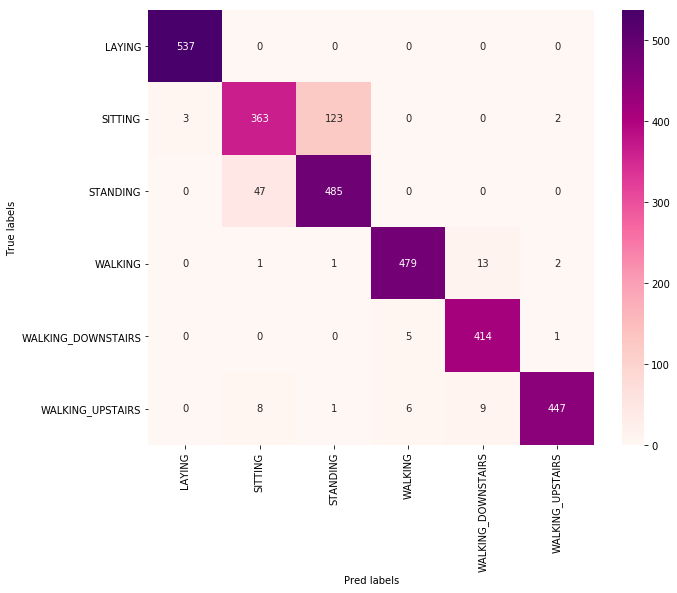

In [36]:
Y_pred = saved_model2.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

#### Observation :-

With a simple 2 LSTM layer with 32 hidden layers and dropout layer architecture we got 92.46% accuracy and a multi class log-loss of 0.34 which is categorical cross entropy.


### Model with 2 LSTM layers with 64 hidden units and Dropout

In [48]:
import warnings
warnings.filterwarnings("ignore")

# Initializing parameters
epochs = 20
batch_size = 32

# Initiliazing the sequential model
model3 = Sequential()
# Adding LSTM and Configuring the parameters
model3.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True))
model3.add(BatchNormalization())
# Adding a dropout layer , to avoid overfitting
model3.add(Dropout(0.8))
# Adding LSTM layer
model3.add(LSTM(64))
# Adding dropout
model3.add(Dropout(0.8))
# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes, activation='sigmoid'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 64)           256       
_________________________________________________________________
dropout_17 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 52,614
Trainable params: 52,486
Non-trainable params: 128
_________________________________________________________________


In [49]:
import warnings
warnings.filterwarnings("ignore")


In [50]:
# Reference -   https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://keras.io/callbacks/
import warnings
warnings.filterwarnings("ignore")

# Compiling the model  , loss is categorical_crossentropy , as the problem is multi-class classification
model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# specifying the filepath to store the best model 
filepath = "HAR_model3_LSTM.hdf5"
# early stopping
es3 = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=15)
# model checkpoint to save the model with best accuracy
mc3 = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# Training the model
history = model3.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs, verbose=2, callbacks=[es3, mc3])

# Saving the best model
saved_model3 = load_model('HAR_model3_LSTM.hdf5')


Train on 7352 samples, validate on 2947 samples
Epoch 1/20
 - 80s - loss: 1.2419 - acc: 0.5537 - val_loss: 0.8814 - val_acc: 0.6634

Epoch 00001: val_acc improved from -inf to 0.66339, saving model to HAR_model3_LSTM.hdf5
Epoch 2/20
 - 74s - loss: 0.8702 - acc: 0.6318 - val_loss: 2.1946 - val_acc: 0.4157

Epoch 00002: val_acc did not improve from 0.66339
Epoch 3/20
 - 74s - loss: 0.7685 - acc: 0.6602 - val_loss: 0.7095 - val_acc: 0.7160

Epoch 00003: val_acc improved from 0.66339 to 0.71598, saving model to HAR_model3_LSTM.hdf5
Epoch 4/20
 - 73s - loss: 0.7044 - acc: 0.7013 - val_loss: 1.1912 - val_acc: 0.6535

Epoch 00004: val_acc did not improve from 0.71598
Epoch 5/20
 - 74s - loss: 0.6283 - acc: 0.7462 - val_loss: 0.7932 - val_acc: 0.7248

Epoch 00005: val_acc improved from 0.71598 to 0.72480, saving model to HAR_model3_LSTM.hdf5
Epoch 6/20
 - 76s - loss: 0.5603 - acc: 0.8047 - val_loss: 0.4771 - val_acc: 0.8629

Epoch 00006: val_acc improved from 0.72480 to 0.86291, saving model t

### Plotting the error plot

Test score: 0.28211334944713906
Test accuracy: 0.9168646080760094


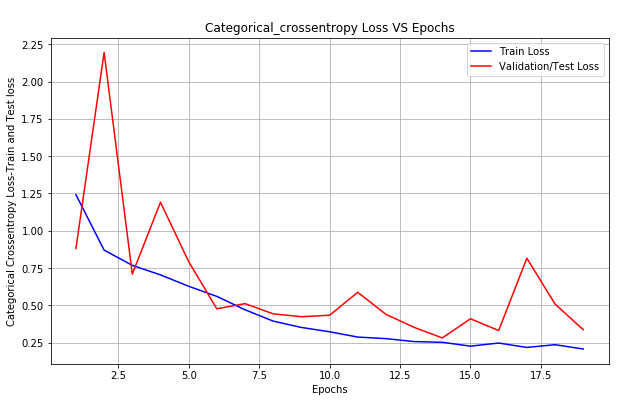

In [51]:
# Evaluating the model on test data
score3 = saved_model3.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score3[0]) 
print('Test accuracy:', score3[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, epochs+1))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

### Confusion matrix

In [52]:
# Utility function to print the confusion matrix
import seaborn as sns
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    plt.figure(1,figsize=(10,8))
    df=pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels'])
    sns.heatmap(df, annot=True,cmap='RdPu',fmt='g')
    return pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels']) 

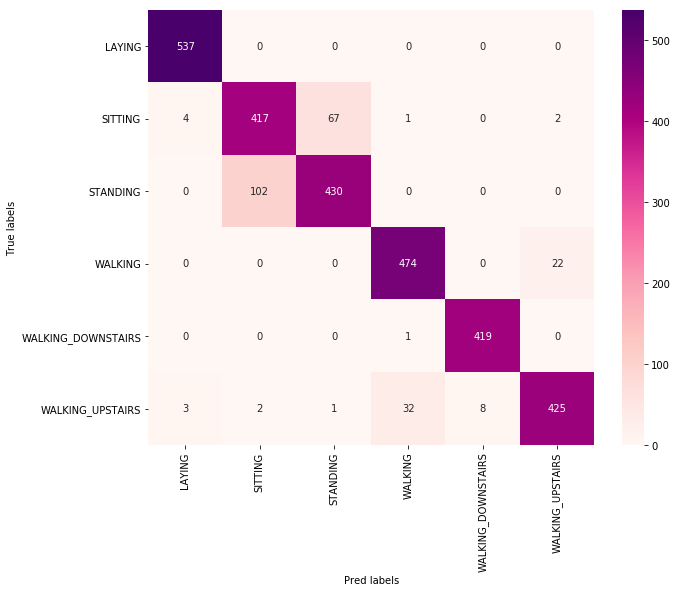

In [53]:
Y_pred = saved_model3.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

#### Observation :-

With a architecture of 2 LSTM layers and with 64 hidden layers and dropout of 0.8,  we got 91.68% accuracy and a multi class log-loss of 0.28 which is categorical cross entropy.


## Bi-Directional  LSTM model with 32 hidden units and Dropout

In [55]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Bidirectional

# Initializing parameters
epochs = 30
batch_size = 32

# Initiliazing the sequential model
model4 = Sequential()
# Adding LSTM and Configuring the parameters
model4.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(timesteps, input_dim), merge_mode='concat'))
model4.add(BatchNormalization())
# Adding a dropout layer , to avoid overfitting
model4.add(Dropout(0.7))
# Adding LSTM layer
model4.add(LSTM(32))
# Adding dropout
model4.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='softmax'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128, 64)           10752     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 64)           256       
_________________________________________________________________
dropout_19 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 198       
Total params: 23,622
Trainable params: 23,494
Non-trainable params: 128
_________________________________________________________________


In [56]:
import warnings
warnings.filterwarnings("ignore")


In [57]:
# Reference -   https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://keras.io/callbacks/
# https://keras.io/layers/wrappers/

import warnings
warnings.filterwarnings("ignore")

# Compiling the model  , loss is categorical_crossentropy , as the problem is multi-class classification
model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# specifying the filepath to store the best model 
filepath = "HAR_model4_LSTM.hdf5"
# early stopping
es4 = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
# model checkpoint to save the model with best accuracy
mc4 = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# Training the model
history = model4.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs, verbose=2, callbacks=[es4, mc4])

# Saving the best model
saved_model4 = load_model('HAR_model4_LSTM.hdf5')


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 88s - loss: 1.1461 - acc: 0.5445 - val_loss: 0.7891 - val_acc: 0.6685

Epoch 00001: val_acc improved from -inf to 0.66848, saving model to HAR_model4_LSTM.hdf5
Epoch 2/30
 - 79s - loss: 0.7385 - acc: 0.6994 - val_loss: 0.5878 - val_acc: 0.7788

Epoch 00002: val_acc improved from 0.66848 to 0.77876, saving model to HAR_model4_LSTM.hdf5
Epoch 3/30
 - 75s - loss: 0.5622 - acc: 0.7886 - val_loss: 0.8105 - val_acc: 0.7299

Epoch 00003: val_acc did not improve from 0.77876
Epoch 4/30
 - 75s - loss: 0.4429 - acc: 0.8508 - val_loss: 0.7568 - val_acc: 0.7475

Epoch 00004: val_acc did not improve from 0.77876
Epoch 5/30
 - 75s - loss: 0.3470 - acc: 0.8920 - val_loss: 0.6392 - val_acc: 0.8096

Epoch 00005: val_acc improved from 0.77876 to 0.80964, saving model to HAR_model4_LSTM.hdf5
Epoch 6/30
 - 92s - loss: 0.3279 - acc: 0.8979 - val_loss: 0.4440 - val_acc: 0.8755

Epoch 00006: val_acc improved from 0.80964 to 0.87547, saving model t

### Plotting the error plot

Test score: 0.32075892655986304
Test accuracy: 0.9273837801153716


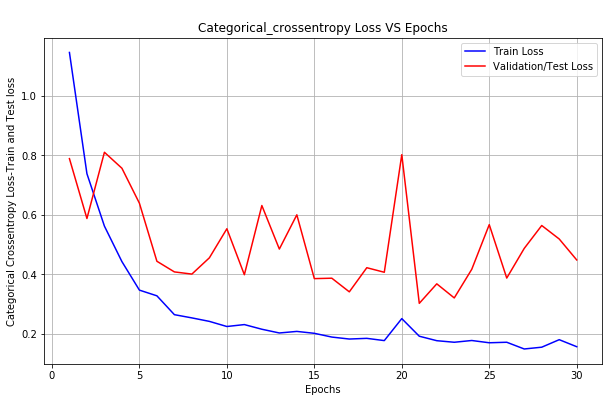

In [58]:
# Evaluating the model on test data
score4 = saved_model4.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score4[0]) 
print('Test accuracy:', score4[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, epochs+1))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

### Confusion matrix

In [59]:
# Utility function to print the confusion matrix
import seaborn as sns
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    plt.figure(1,figsize=(10,8))
    df=pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels'])
    sns.heatmap(df, annot=True,cmap='RdPu',fmt='g')
    return pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels']) 

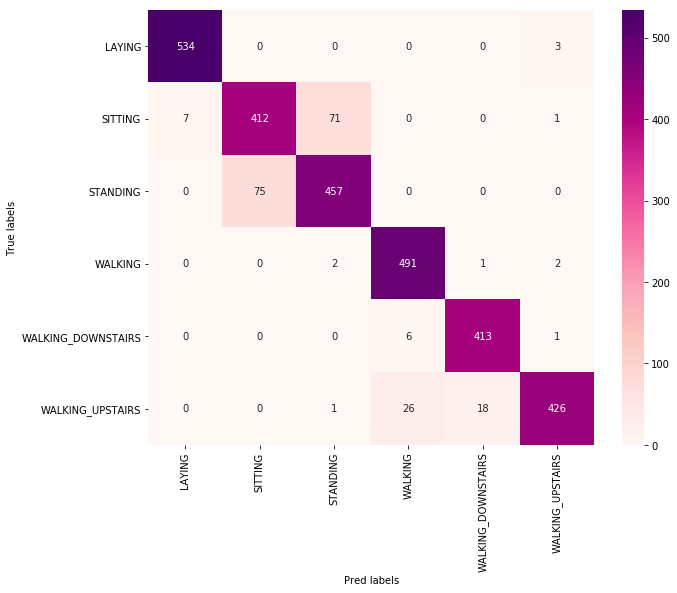

In [60]:
Y_pred = saved_model4.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

#### Observation :-

With a architecture of Bi-Directional LSTM model with 32 hidden units and Dropout of 0.7,  we got 92.73% accuracy and a multi class log-loss of 0.32 which is categorical cross entropy.


## Bi-Directional LSTM model with 64 hidden units and Dropout


In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Bidirectional

# Initializing parameters
epochs = 30
batch_size = 32

# Initiliazing the sequential model
model5 = Sequential()
# Adding LSTM and Configuring the parameters
model5.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, input_dim), merge_mode='concat'))
model5.add(BatchNormalization())
# Adding a dropout layer , to avoid overfitting
model5.add(Dropout(0.7))
# Adding LSTM layer
model5.add(LSTM(64))
# Adding dropout
model5.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes, activation='softmax'))
model5.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128, 128)          37888     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)      

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Reference -   https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://keras.io/callbacks/
# https://keras.io/layers/wrappers/

import warnings
warnings.filterwarnings("ignore")

# Compiling the model  , loss is categorical_crossentropy , as the problem is multi-class classification
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# specifying the filepath to store the best model 
filepath = "HAR_model5_LSTM.hdf5"
# early stopping
es5 = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
# model checkpoint to save the model with best accuracy
mc5 = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# Training the model
history = model5.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs, verbose=2, callbacks=[es5, mc5])

# Saving the best model
saved_model5 = load_model('HAR_model5_LSTM.hdf5')


Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 125s - loss: 0.9334 - acc: 0.6255 - val_loss: 0.5767 - val_acc: 0.7693

Epoch 00001: val_acc improved from -inf to 0.76926, saving model to HAR_model5_LSTM.hdf5
Epoch 2/30
 - 111s - loss: 0.4787 - acc: 0.8264 - val_loss: 0.3236 - val_acc: 0.8860

Epoch 00002: val_acc improved from 0.76926 to 0.88599, saving model to HAR_model5_LSTM.hdf5
Epoch 3/30
 - 111s - loss: 0.2785 - acc: 0.9053 - val_loss: 0.5888 - val_acc: 0.8035

Epoch 00003: val_acc did not improve from 0.88599
Epoch 4/30
 - 112s - loss: 0.2536 - acc: 0.9136 - val_loss: 0.3555 - val_acc: 0.8860

Epoch 00004: val_acc did not improve from 0.88599
Epoch 5/30
 - 111s - loss: 0.1990 - acc: 0.9267 - val_loss: 0.4107 - val_acc: 0.8877

Epoch 00005: val_acc improved from 0.88599 to 0.88768, saving model to HAR_model5_LSTM.hdf5
Epoch 6/30
 - 112s - loss: 0.2419 - acc: 0.9142 - val_loss: 0.3230 - val_acc: 0.9030

Epoch 00006: va

### Plotting the error plot

Test score: 0.23872518167037293
Test accuracy: 0.9246691550729556


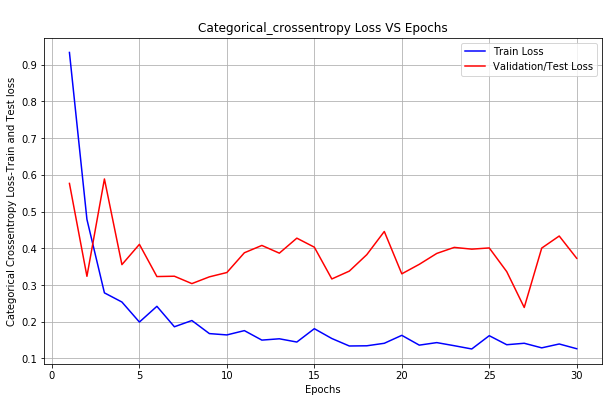

In [19]:
# Evaluating the model on test data
score5 = saved_model5.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score5[0]) 
print('Test accuracy:', score5[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, epochs+1))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

### Confusion matrix

In [20]:
# Utility function to print the confusion matrix
import seaborn as sns
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    plt.figure(1,figsize=(10,8))
    df=pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels'])
    sns.heatmap(df, annot=True,cmap='RdPu',fmt='g')
    return pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels']) 

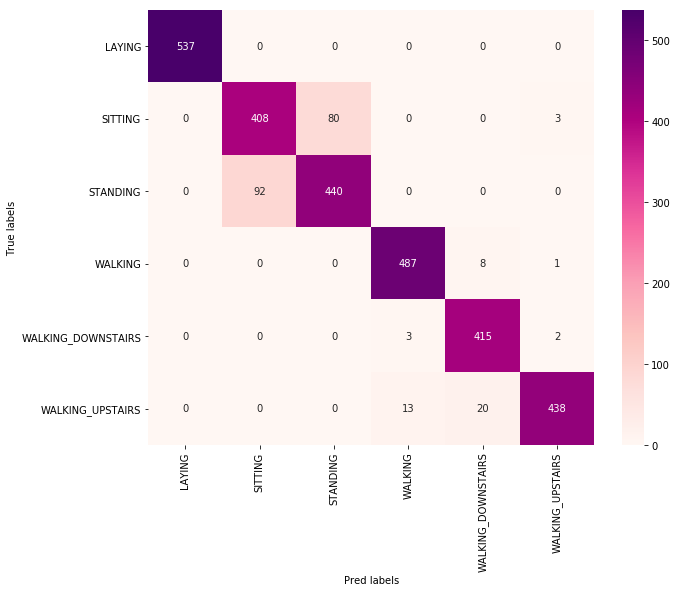

In [21]:
Y_pred = saved_model5.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

#### Observation :-

With a architecture of Bi-Directional LSTM model with 64 hidden units and Dropout of 0.7,  we got 92.46% accuracy and a multi class log-loss of 0.23 which is categorical cross entropy.


## Bi-Directional LSTM model with 48 and 64 hidden units and Dropout

In [26]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Bidirectional

# Initializing parameters
epochs = 30
batch_size = 32

# Initiliazing the sequential model
model6 = Sequential()
# Adding LSTM and Configuring the parameters
model6.add(Bidirectional(LSTM(48, return_sequences=True), input_shape=(timesteps, input_dim), merge_mode='concat'))
model6.add(BatchNormalization())
# Adding a dropout layer , to avoid overfitting
model6.add(Dropout(0.4))
# Adding LSTM layer
model6.add(LSTM(64))
# Adding dropout
model6.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model6.add(Dense(n_classes, activation='softmax'))
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 128, 96)           22272     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 96)           384       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 96)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                41216     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 64,262
Trainable params: 64,070
Non-trainable params: 192
_________________________________________________________________


In [27]:
# Reference -   https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://keras.io/callbacks/
# https://keras.io/layers/wrappers/

import warnings
warnings.filterwarnings("ignore")

# Compiling the model  , loss is categorical_crossentropy , as the problem is multi-class classification
model6.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# specifying the filepath to store the best model 
filepath = "HAR_model6_LSTM.hdf5"
# early stopping
es6 = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
# model checkpoint to save the model with best accuracy
mc6 = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# Training the model
history = model6.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs, verbose=2, callbacks=[es6, mc6])

# Saving the best model
saved_model6 = load_model('HAR_model6_LSTM.hdf5')


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 124s - loss: 0.6080 - acc: 0.7764 - val_loss: 0.4049 - val_acc: 0.8558

Epoch 00001: val_acc improved from -inf to 0.85579, saving model to HAR_model6_LSTM.hdf5
Epoch 2/30
 - 118s - loss: 0.2499 - acc: 0.9128 - val_loss: 0.3157 - val_acc: 0.8792

Epoch 00002: val_acc improved from 0.85579 to 0.87920, saving model to HAR_model6_LSTM.hdf5
Epoch 3/30
 - 118s - loss: 0.1737 - acc: 0.9343 - val_loss: 0.2889 - val_acc: 0.9053

Epoch 00003: val_acc improved from 0.87920 to 0.90533, saving model to HAR_model6_LSTM.hdf5
Epoch 4/30
 - 127s - loss: 0.1656 - acc: 0.9369 - val_loss: 0.2348 - val_acc: 0.9192

Epoch 00004: val_acc improved from 0.90533 to 0.91924, saving model to HAR_model6_LSTM.hdf5
Epoch 5/30
 - 118s - loss: 0.1479 - acc: 0.9416 - val_loss: 0.3567 - val_acc: 0.8843

Epoch 00005: val_acc did not improve from 0.91924
Epoch 6/30
 - 112s - loss: 0.1433 - acc: 0.9437 - val_loss: 0.2659 - val_acc: 0.9332

Epoch 00006: val_acc 

### Ploting the error plot 

Test score: 0.21072815701344155
Test accuracy: 0.9426535459789617


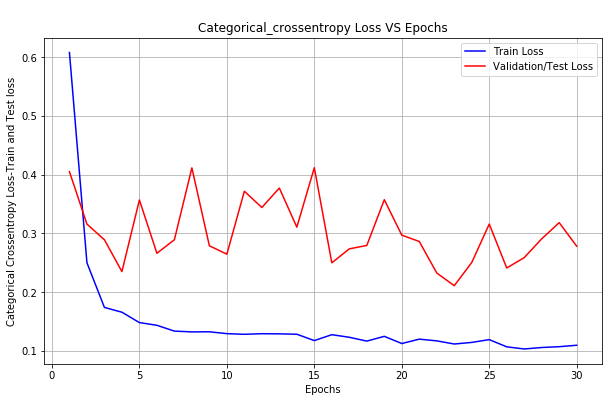

In [28]:
# Evaluating the model on test data
score6 = saved_model6.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score6[0]) 
print('Test accuracy:', score6[1])

# Plotting the results
# list of epoch numbers
x = list(range(1, epochs+1))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
vy = history.history['val_loss']

# Training loss
ty = history.history['loss']
# calling the dynamic function to draw the plot
plt_dynamic(x, vy, ty)

### Confusion matrix

In [29]:
# Utility function to print the confusion matrix
import seaborn as sns
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    plt.figure(1,figsize=(10,8))
    df=pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels'])
    sns.heatmap(df, annot=True,cmap='RdPu',fmt='g')
    return pd.crosstab(Y_true, Y_pred, rownames=['True labels'], colnames=['Pred labels']) 

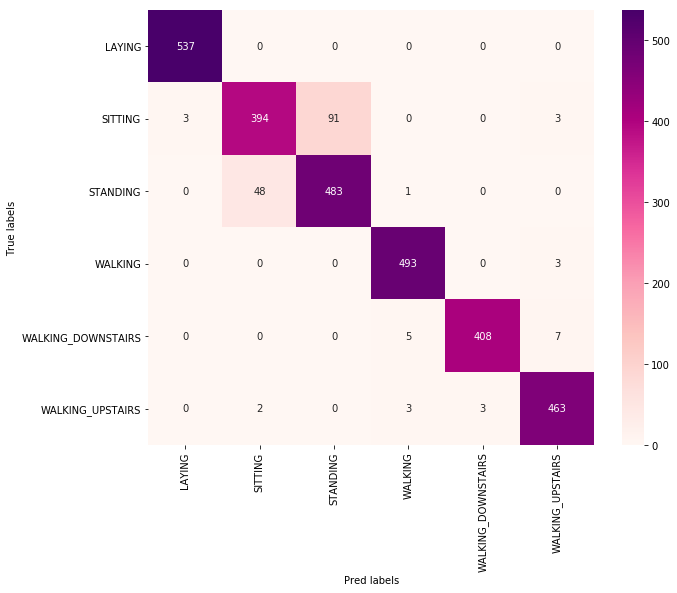

In [30]:
Y_pred = saved_model6.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

#### Observation :-

With a architecture of Bi-Directional LSTM model with 48 and 64 hidden units and Dropout of 0.4 and 0.5,  we got 94.26% accuracy and a multi class log-loss of 0.21 which is categorical cross entropy.


## Models Summarization

In [37]:
from pandas import DataFrame
from pandas import DataFrame
HAR = {'Model':['1-LSTM layer with 32 hidden units','1 LSTM layer with 64 hidden units','2 LSTM layers with 32 hidden units',
               '2 LSTM layers with 64 hidden units','Bi-Directional LSTM model with 32 hidden units',
               'Bi-Directional LSTM model with 64 hidden units','Bi-Directional LSTM model with 48 and 64 hidden units'],
               'Dropout':['0.5','0.7','0.7','0.8','0.7','0.7','0.4,0.5'],
               'Activation':['softmax','softmax','softmax','Sigmoid','softmax','softmax','softmax'],
               'Optimizer':['rmsprop','rmsprop','rmsprop','rmsprop','rmsprop','adam','rmsprop'],
               'Loss':['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                      'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
               'Training accuracy':['0.94','0.935','0.93','0.918','0.93','0.94','0.95'], 
               'Test accuracy':['0.898','0.932','0.924','0.916','0.927','0.924','0.94']}

In [38]:
Final_conclusions = DataFrame(HAR)
Final_conclusions

,Model,Dropout,Activation,Optimizer,Loss,Training accuracy,Test accuracy
0,1-LSTM layer with 32 hidden units,0.5,softmax,rmsprop,categorical_crossentropy,0.94,0.898
1,1 LSTM layer with 64 hidden units,0.7,softmax,rmsprop,categorical_crossentropy,0.935,0.932
2,2 LSTM layers with 32 hidden units,0.7,softmax,rmsprop,categorical_crossentropy,0.93,0.924
3,2 LSTM layers with 64 hidden units,0.8,Sigmoid,rmsprop,categorical_crossentropy,0.918,0.916
4,Bi-Directional LSTM model with 32 hidden units,0.7,softmax,rmsprop,categorical_crossentropy,0.93,0.927
5,Bi-Directional LSTM model with 64 hidden units,0.7,softmax,adam,categorical_crossentropy,0.94,0.924
6,Bi-Directional LSTM model with 48 and 64 hidde...,"0.4,0.5",softmax,rmsprop,categorical_crossentropy,0.95,0.94


#### The best accuracy I got after training Bi-Directional LSTM model on Raw data is 0.947

##  Conclusions:-


From the above observations we can observe, 

1. All the above models are trained on Raw data.
2. Model with Bi-Directional LSTM with 48 and 64 hidden units and dropouts of 0.4 and 0.5 gave good accuracy of 0.9427.
3. All other models have almost similar accuracy which is above 90%, even with different LSTM layes, different dropout rates and different number of hidden units.
4. With each epoch the accuracy increased.
5. I used sigmoid, softmax activations and rmsprop, adam optimizers for LSTM and Bi-Directional LSTM.
6. Bi-Directional LSTM models worked well than the simple LSTM models and gave good accuracy than the other models.
7. The Raw data with deep learning models gave good accuracy which is as good as the accuracy of expert engineered features  with classical Machine learning models.
8. If we train Deep learning models on expert engineered features , we can get still more better accuracy similar to classical Machine learning models.